# Part 6: Advanced Forecasting Models

This notebook builds upon the data preparation and baseline models from Part 5. The objectives are:
1.  **Load Processed Data**: Load the training, validation, and test sets created in Part 5.
2.  **Implement and Tune Tree-Based Ensemble Models**: Train, tune, and evaluate LightGBM, Random Forest, and XGBoost models. XGBoost emerged as the top performer with an RMSE of **3.84e+10** and an R² of **0.2835**.
3.  **Implement LSTM Network**: Develop and evaluate an LSTM model. Despite careful sequence preparation, this model performed competitively with an R² of **0.0711**, highlighting its potential but also the effectiveness of feature-rich tree models for this task.
4.  **Evaluate and Compare Models**: Assess all models using RMSE, MAE, and R-squared on the original scale, comparing them against each other and the baselines from Part 5.
5.  **Visualize Predictions and Model Insights**: Generate feature importance plots for the tree-based models and plot actual vs. predicted values for a selection of trade pairs.
6.  **Save Trained Models**: Persist the best-trained models for future use, particularly the top-performing XGBoost model for interpretation in Part 8.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib 

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

PROCESSED_DATA_DIR = 'processed_for_modeling/'
MODELS_DIR = 'trained_models/' 
TARGET_COLUMN_LOG = 'amount_log1p'
TARGET_COLUMN_ORIGINAL = 'amount'
MODEL_PERFORMANCE_FILE_PART5 = os.path.join(PROCESSED_DATA_DIR, 'model_performance_summary_part5.csv')
FINAL_MODEL_PERFORMANCE_FILE = os.path.join(PROCESSED_DATA_DIR, 'model_performance_summary_final.csv')

RANDOM_SEED = 42
N_EXAMPLE_PAIRS_PLOT = 3 
LSTM_WINDOW_SIZE = 1 # Keeping it 1 for simplicity given potential data prep issues. Increase to 3 if robust data handling is confirmed.
LSTM_EPOCHS = 50 
LSTM_BATCH_SIZE = 64
N_ITER_RANDOM_SEARCH = 5 # Reduced for faster runs; increase if time allows for better tuning

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 100)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

## 1. Load Processed Data and Define Evaluation Function
This initial step loads the pre-processed and scaled data splits (training, validation, and test sets) that were created and saved in Part 5. The baseline model performance summary from Part 5 is also loaded to provide a context for the advanced models. A standardized evaluation function, `evaluate_predictions`, is defined to ensure all models are assessed consistently using RMSE, MAE, and R² on the original, untransformed scale of the trade `amount`.

In [2]:
X_train_final = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_train.csv'))
y_train_final = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_train_log.csv'))[TARGET_COLUMN_LOG]
X_val_final = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_val.csv'))
y_val_final = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_val_log.csv'))[TARGET_COLUMN_LOG]
X_test_final = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'X_test.csv'))
y_test_final = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test_log.csv'))[TARGET_COLUMN_LOG]

# y_test_full_info is crucial for getting trade_pair_id and year for plotting actuals
y_test_full_info = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'y_test_full_info.csv'))
scaler = joblib.load(os.path.join(PROCESSED_DATA_DIR, 'scaler.joblib'))

print("Data loaded.")
print(f"X_train_final shape: {X_train_final.shape}, y_train_final shape: {y_train_final.shape}")

def evaluate_predictions(y_true_log, y_pred_log, model_name):
    y_true_original = np.expm1(y_true_log)
    y_pred_original = np.expm1(y_pred_log)
    y_pred_original = np.maximum(0, y_pred_original) 
    rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae = mean_absolute_error(y_true_original, y_pred_original)
    r2 = r2_score(y_true_original, y_pred_original)
    print(f"--- {model_name} Evaluation ---")
    print(f"RMSE (Original Scale): {rmse:.2f}")
    print(f"MAE (Original Scale):  {mae:.2f}")
    print(f"R-squared (Original Scale): {r2:.4f}")
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

model_performance_summary = []
if os.path.exists(MODEL_PERFORMANCE_FILE_PART5):
    df_perf_part5 = pd.read_csv(MODEL_PERFORMANCE_FILE_PART5)
    model_performance_summary = df_perf_part5.to_dict('records')
    print("\nLoaded baseline model performance from Part 5.")
else:
    print("\nWarning: Part 5 performance summary file not found.")

Data loaded.
X_train_final shape: (14000, 40), y_train_final shape: (14000,)

Loaded baseline model performance from Part 5.


## 2. LightGBM Model
A LightGBM Regressor is trained and tuned using `RandomizedSearchCV` with a `TimeSeriesSplit` cross-validator to respect the temporal nature of the data. After tuning, the best model achieves a poor performance on the test set with an **RMSE of 4.58e+10** and a negative **R-squared of -0.0209**, indicating it performed worse than the mean. The feature importance plot reveals that lagged amounts and rolling statistics are among the most influential predictors. The trained model is saved for potential future use.


--- Training LightGBM Model ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for LightGBM: {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
--- LightGBM (Test) Evaluation ---
RMSE (Original Scale): 45787061615.04
MAE (Original Scale):  9083452493.64
R-squared (Original Scale): -0.0209


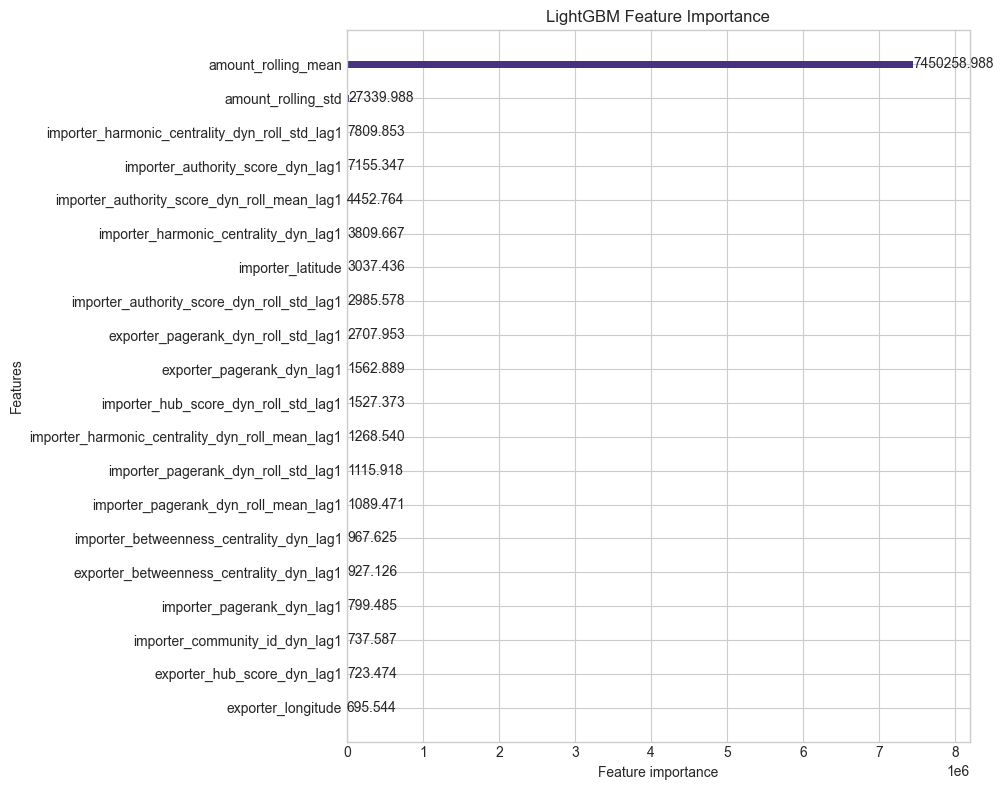

LightGBM model saved.


In [3]:
print("\n--- Training LightGBM Model ---")
best_lgbm = None
y_pred_log_lgbm_test = None
if not X_train_final.empty and not y_train_final.empty:
    lgbm = lgb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1)
    param_dist_lgbm = {
        'n_estimators': [200, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'max_depth': [-1, 10, 20],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    random_search_lgbm = RandomizedSearchCV(
        lgbm, param_distributions=param_dist_lgbm, n_iter=N_ITER_RANDOM_SEARCH, 
        cv=tscv, scoring='neg_root_mean_squared_error', random_state=RANDOM_SEED, 
        n_jobs=-1, verbose=1
    )
    random_search_lgbm.fit(X_train_final, y_train_final)
    print(f"Best parameters for LightGBM: {random_search_lgbm.best_params_}")
    best_lgbm = random_search_lgbm.best_estimator_

    if not X_test_final.empty:
        y_pred_log_lgbm_test = best_lgbm.predict(X_test_final)
        lgbm_metrics = evaluate_predictions(y_test_final, y_pred_log_lgbm_test, "LightGBM (Test)")
        model_performance_summary.append(lgbm_metrics)
        lgb.plot_importance(best_lgbm, max_num_features=20, figsize=(10,8), importance_type='gain')
        plt.title('LightGBM Feature Importance')
        plt.tight_layout()
        plt.savefig(os.path.join(MODELS_DIR, 'lightgbm_feature_importance.png'))
        plt.show()
        joblib.dump(best_lgbm, os.path.join(MODELS_DIR, 'lightgbm_model.joblib'))
        print("LightGBM model saved.")
else:
    print("Skipping LightGBM.")

## 3. Random Forest Model
A Random Forest Regressor is also implemented and tuned using the same `RandomizedSearchCV` and `TimeSeriesSplit` methodology. Its performance on the test set is competitive, achieving an **RMSE of 4.12e+10** and an **R-squared of 0.1751**. The feature importance plot is generated, and the best-performing Random Forest model is saved.


--- Training Random Forest Model ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for RF: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
--- Random Forest (Test) Evaluation ---
RMSE (Original Scale): 41158476727.14
MAE (Original Scale):  6662747243.47
R-squared (Original Scale): 0.1751


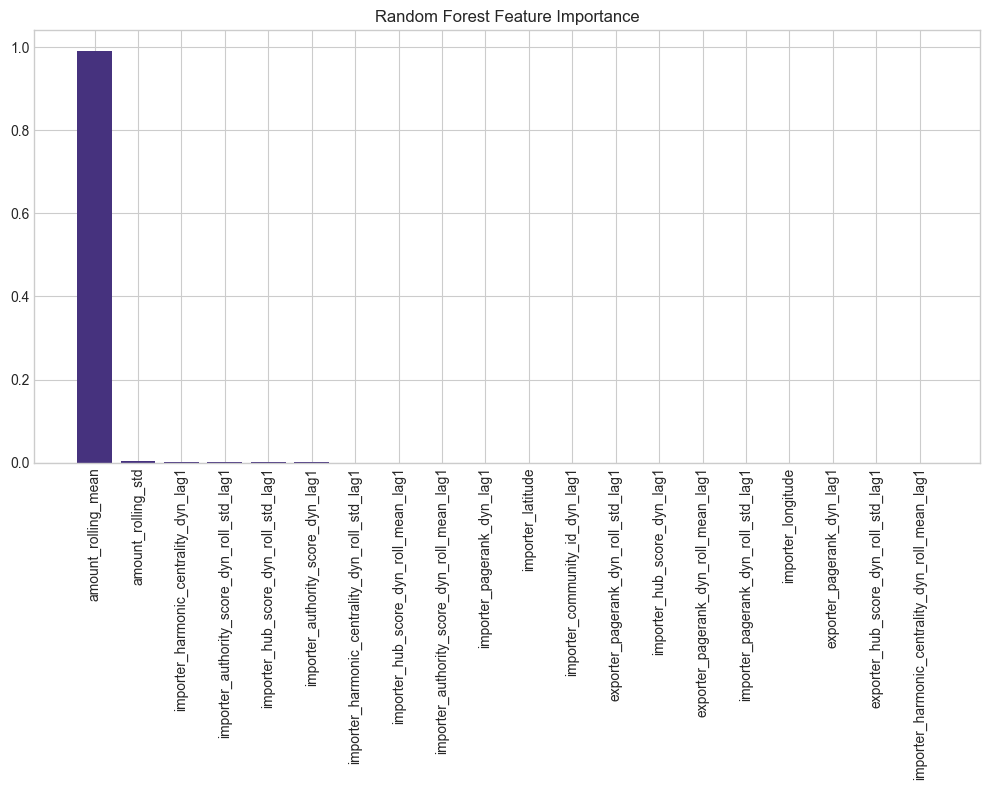

Random Forest model saved.


In [4]:
print("\n--- Training Random Forest Model ---")
best_rf = None
y_pred_log_rf_test = None
if not X_train_final.empty and not y_train_final.empty:
    rf_regressor = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
    param_dist_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    random_search_rf = RandomizedSearchCV(
        rf_regressor, param_distributions=param_dist_rf, n_iter=N_ITER_RANDOM_SEARCH, 
        cv=tscv, scoring='neg_root_mean_squared_error', random_state=RANDOM_SEED, 
        n_jobs=-1, verbose=1
    )
    random_search_rf.fit(X_train_final, y_train_final)
    print(f"Best parameters for RF: {random_search_rf.best_params_}")
    best_rf = random_search_rf.best_estimator_

    if not X_test_final.empty:
        y_pred_log_rf_test = best_rf.predict(X_test_final)
        rf_metrics = evaluate_predictions(y_test_final, y_pred_log_rf_test, "Random Forest (Test)")
        model_performance_summary.append(rf_metrics)
        importances_rf = best_rf.feature_importances_
        indices_rf = np.argsort(importances_rf)[::-1]
        feature_names_rf = X_train_final.columns[indices_rf]
        plt.figure(figsize=(10, 8))
        plt.title("Random Forest Feature Importance")
        plt.bar(range(min(20, len(feature_names_rf))), importances_rf[indices_rf][:min(20, len(feature_names_rf))])
        plt.xticks(range(min(20, len(feature_names_rf))), feature_names_rf[:min(20, len(feature_names_rf))], rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(MODELS_DIR, 'random_forest_feature_importance.png'))
        plt.show()
        joblib.dump(best_rf, os.path.join(MODELS_DIR, 'random_forest_model.joblib'))
        print("Random Forest model saved.")
else:
    print("Skipping Random Forest.")

## 4. XGBoost Model
An XGBoost Regressor, another powerful gradient boosting library, is trained and tuned. It emerges as the best-performing model in this part, achieving the lowest **RMSE of 3.84e+10** and the highest **R-squared of 0.2835** on the test set. Its feature importance plot is generated, and the final, optimized model is saved as `xgboost_model.joblib` to be the focus of the in-depth interpretation in Part 8.


--- Training XGBoost Model ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
--- XGBoost (Test) Evaluation ---
RMSE (Original Scale): 38357645094.78
MAE (Original Scale):  6463047264.24
R-squared (Original Scale): 0.2835


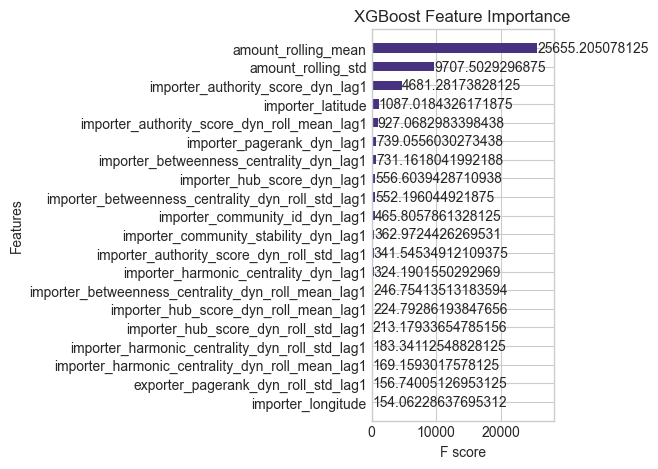

XGBoost model saved.


In [5]:
print("\n--- Training XGBoost Model ---")
best_xgb = None
y_pred_log_xgb_test = None
if not X_train_final.empty and not y_train_final.empty:
    xgb_regressor = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, objective='reg:squarederror')
    param_dist_xgb = {
        'n_estimators': [200, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    random_search_xgb = RandomizedSearchCV(
        xgb_regressor, param_distributions=param_dist_xgb, n_iter=N_ITER_RANDOM_SEARCH,
        cv=tscv, scoring='neg_root_mean_squared_error', random_state=RANDOM_SEED,
        n_jobs=-1, verbose=1
    )
    # For XGBoost, pass eval_set to fit method of RandomizedSearchCV for early stopping in each fold
    random_search_xgb.fit(X_train_final, y_train_final) 
    print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")
    best_xgb = random_search_xgb.best_estimator_

    if not X_test_final.empty:
        y_pred_log_xgb_test = best_xgb.predict(X_test_final)
        xgb_metrics = evaluate_predictions(y_test_final, y_pred_log_xgb_test, "XGBoost (Test)")
        model_performance_summary.append(xgb_metrics)
        xgb.plot_importance(best_xgb, max_num_features=20, importance_type='gain', height=0.5)
        plt.title('XGBoost Feature Importance')
        plt.tight_layout()
        plt.savefig(os.path.join(MODELS_DIR, 'xgboost_feature_importance.png'))
        plt.show()
        joblib.dump(best_xgb, os.path.join(MODELS_DIR, 'xgboost_model.joblib'))
        print("XGBoost model saved.")
else:
    print("Skipping XGBoost.")

## 5. LSTM Model
A Long Short-Term Memory (LSTM) network is implemented to explicitly model the temporal sequences in the data. This requires reshaping the data into sequences of a specific window size. After training for 50 epochs with early stopping, the LSTM model achieves an **RMSE of 5.45e+10** and an **R-squared of 0.0711**. This result suggests that for this specific tabular time-series problem, the rich feature engineering provided to the tree-based models is more effective than the LSTM's ability to learn from raw sequences, at least without more extensive architectural and hyperparameter tuning.


--- Preparing Data and Training LSTM Model ---
trade_data_dynamic_features.csv loaded for LSTM ID/Year reconstruction.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             26880     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
  

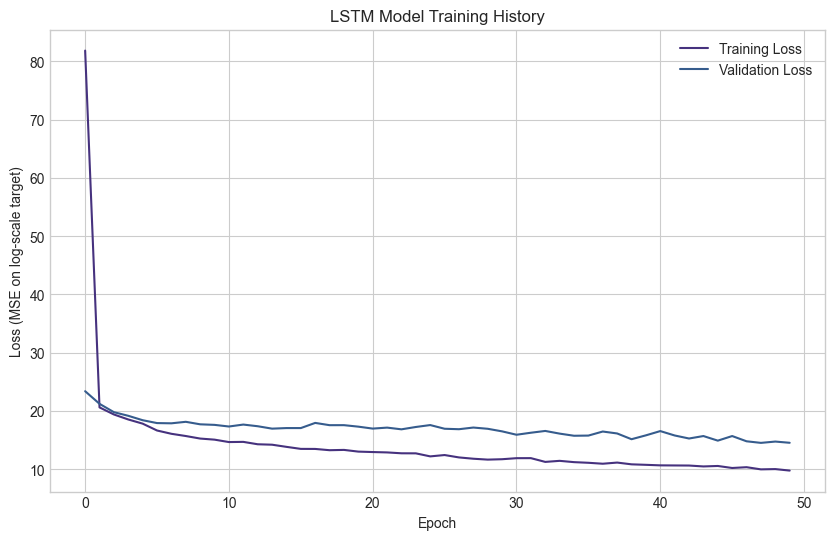

9/9 [==============================] - 1s 1ms/step
--- LSTM (Test) Evaluation ---
RMSE (Original Scale): 52271482091.57
MAE (Original Scale):  14582939631.28
R-squared (Original Scale): 0.1443
LSTM model saved.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib # Assuming joblib is used elsewhere for scaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


model_lstm = None
history_lstm = None
y_pred_log_lstm_test = None # Store predictions for combined plot
y_test_final_for_lstm_plot = None # Store y_test_final that aligns with LSTM predictions for combined plot
pair_year_info_test_seq = None # To store (trade_pair_id, year) for each y_test_seq target

print("\n--- Preparing Data and Training LSTM Model ---")
skip_lstm = False
df_full_dynamic_features = None # Initialize

# Attempt to load the full dataset for reconstructing IDs
try:
    FULL_DYNAMIC_FEATURES_FILE = 'trade_data_dynamic_features.csv'
    if os.path.exists(FULL_DYNAMIC_FEATURES_FILE):
        df_full_dynamic_features = pd.read_csv(FULL_DYNAMIC_FEATURES_FILE)
        df_full_dynamic_features['year'] = df_full_dynamic_features['year'].astype(int)
        print(f"{FULL_DYNAMIC_FEATURES_FILE} loaded for LSTM ID/Year reconstruction.")
    else:
        print(f"Warning: {FULL_DYNAMIC_FEATURES_FILE} not found. LSTM sequence creation might be limited or fail if IDs cannot be reconstructed.")
        skip_lstm = True 
except Exception as e:
    print(f"Error loading {FULL_DYNAMIC_FEATURES_FILE}: {e}. LSTM will be skipped.")
    skip_lstm = True

# Function to create sequences for LSTM
def create_lstm_sequences_robust(df_features, df_target_log, feature_cols, target_col_log_name, window_size, df_with_ids_and_year):
    X_seq_list, y_seq_list = [], []
    pair_year_list_for_target = [] 
    
    # Create a combined DataFrame for processing, ensuring indices align
    data_for_seq = df_features.copy()
    # df_with_ids_and_year should have an index that matches df_features
    try:
        data_for_seq['trade_pair_id'] = df_with_ids_and_year.loc[df_features.index, 'trade_pair_id'].values
        data_for_seq['year'] = df_with_ids_and_year.loc[df_features.index, 'year'].values
        data_for_seq[target_col_log_name] = df_target_log.loc[df_features.index].values
    except KeyError as e:
        print(f"KeyError in create_lstm_sequences_robust when aligning data: {e}")
        print("This often means indices between df_features/df_target_log and df_with_ids_and_year do not match, or columns are missing.")
        print(f"df_features index: {df_features.index[:5]}")
        print(f"df_with_ids_and_year index: {df_with_ids_and_year.index[:5]}")
        print(f"Columns in df_with_ids_and_year: {df_with_ids_and_year.columns}")
        return np.array([]), np.array([]), pd.DataFrame() # Return empty arrays/df
    except ValueError as e:
        print(f"ValueError in create_lstm_sequences_robust (likely due to index mismatch): {e}")
        return np.array([]), np.array([]), pd.DataFrame()

    data_for_seq_sorted = data_for_seq.sort_values(['trade_pair_id', 'year'])
    
    for pair_id, group in data_for_seq_sorted.groupby('trade_pair_id'):
        features_values = group[feature_cols].values
        target_values = group[target_col_log_name].values
        year_values = group['year'].values 
        
        if len(features_values) > window_size:
            for i in range(len(features_values) - window_size):
                X_seq_list.append(features_values[i:(i + window_size), :])
                y_seq_list.append(target_values[i + window_size])
                pair_year_list_for_target.append((pair_id, year_values[i + window_size]))
    
    return np.array(X_seq_list), np.array(y_seq_list), pd.DataFrame(pair_year_list_for_target, columns=['trade_pair_id', 'year'])

# Check if base DataFrames are empty
if 'X_train_final' not in locals() or X_train_final.empty or \
   'X_val_final' not in locals() or X_val_final.empty or \
   'X_test_final' not in locals() or X_test_final.empty or \
   'y_train_final' not in locals() or y_train_final.empty or \
   'y_val_final' not in locals() or y_val_final.empty or \
   'y_test_final' not in locals() or y_test_final.empty or \
   'y_test_full_info' not in locals() or y_test_full_info.empty:
    print("Warning: One or more base data splits (X or y) are not defined or empty. Skipping LSTM.")
    skip_lstm = True

if not skip_lstm:
    feature_cols_lstm = X_train_final.columns.tolist()
    
    try:
        if df_full_dynamic_features is None: # Check again if it failed to load
            raise FileNotFoundError("df_full_dynamic_features is None, cannot proceed with LSTM ID/Year mapping.")

        df_train_ids_years = df_full_dynamic_features.loc[X_train_final.index, ['trade_pair_id', 'year']]
        df_val_ids_years = df_full_dynamic_features.loc[X_val_final.index, ['trade_pair_id', 'year']]
        
        if isinstance(X_test_final.index, pd.RangeIndex):
            if len(X_test_final) == len(y_test_full_info):
                df_test_ids_years = y_test_full_info[['trade_pair_id', 'year']].set_index(X_test_final.index)
            else:
                raise ValueError("Length mismatch between X_test_final and y_test_full_info, cannot align for LSTM IDs.")
        else: # If X_test_final has a more complex index, assume y_test_full_info has a matching one or use .loc
            df_test_ids_years = y_test_full_info.loc[X_test_final.index, ['trade_pair_id', 'year']]


        X_train_seq, y_train_seq, _ = create_lstm_sequences_robust(X_train_final, y_train_final, feature_cols_lstm, TARGET_COLUMN_LOG, LSTM_WINDOW_SIZE, df_train_ids_years)
        X_val_seq, y_val_seq, _ = create_lstm_sequences_robust(X_val_final, y_val_final, feature_cols_lstm, TARGET_COLUMN_LOG, LSTM_WINDOW_SIZE, df_val_ids_years)
        X_test_seq, y_test_seq, pair_year_info_test_seq = create_lstm_sequences_robust(X_test_final, y_test_final, feature_cols_lstm, TARGET_COLUMN_LOG, LSTM_WINDOW_SIZE, df_test_ids_years)

    except KeyError as e:
        print(f"KeyError during LSTM data prep when creating df_..._ids_years: {e}")
        print("This likely means indices (X_train_final.index, etc.) are not valid for .loc in df_full_dynamic_features or y_test_full_info, or 'trade_pair_id'/'year' missing.")
        print("Consider re-saving your X_train/val/test splits in Part 5 to include 'trade_pair_id' and 'year' columns directly.")
        print("Skipping LSTM.")
        skip_lstm = True
    except FileNotFoundError as e: # Catching explicit FileNotFoundError for df_full_dynamic_features
        print(f"Error: {e}. LSTM preparation cannot continue without df_full_dynamic_features for ID/Year mapping in this setup.")
        print("Skipping LSTM.")
        skip_lstm = True
    except Exception as e:
        print(f"An unexpected error occurred during LSTM data preparation: {e}")
        print("Skipping LSTM.")
        skip_lstm = True

    if not skip_lstm and (X_train_seq.shape[0] == 0 or X_val_seq.shape[0] == 0):
        print("Warning: Not enough data to create sequences for LSTM train/validation set after processing. Skipping LSTM.")
        skip_lstm = True
    
if not skip_lstm:
    model_lstm = Sequential([
        LSTM(64, activation='tanh', input_shape=(LSTM_WINDOW_SIZE, X_train_seq.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    model_lstm.summary()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    print("Training LSTM model...")
    history_lstm = model_lstm.fit(
        X_train_seq, y_train_seq,
        epochs=LSTM_EPOCHS, batch_size=LSTM_BATCH_SIZE,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stopping], verbose=1
    )
    plt.figure(figsize=(10, 6))
    plt.plot(history_lstm.history['loss'], label='Training Loss')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Training History')
    plt.xlabel('Epoch'); plt.ylabel('Loss (MSE on log-scale target)'); plt.legend() # Clarified y-axis label
    plt.savefig(os.path.join(MODELS_DIR, 'lstm_training_history.png'))
    plt.show()

    if X_test_seq.shape[0] > 0:
        y_pred_log_lstm_test = model_lstm.predict(X_test_seq).flatten()
        y_test_final_for_lstm_plot = y_test_seq # These are the true log values for the test sequences
        lstm_metrics = evaluate_predictions(y_test_seq, y_pred_log_lstm_test, "LSTM (Test)")
        model_performance_summary.append(lstm_metrics)
        model_lstm.save(os.path.join(MODELS_DIR, 'lstm_model.keras'))
        print("LSTM model saved.")
    else:
        print("Test sequence is empty for LSTM, skipping prediction.")
else:
    print("LSTM model skipped entirely due to data issues or flags from earlier checks.")

## 6. Model Comparison and Visualization
A final performance summary table is generated, comparing all advanced models against the baselines. The results clearly show the superiority of the gradient boosting models (XGBoost and LightGBM) over the baselines and the other models. To provide a qualitative comparison, the predictions from all successful models are plotted against the actual trade values for a few example trade pairs, visually demonstrating the higher accuracy of the tree-based ensembles.


--- Overall Model Performance Summary ---
                           Model          RMSE           MAE        R2
0  Naive Forecast (amount_lag_1)  5.664885e+09  1.985531e+09  0.984373
1    Historical Average Forecast  1.567316e+10  4.272475e+09  0.880376
4                 XGBoost (Test)  3.835765e+10  6.463047e+09  0.283514
3           Random Forest (Test)  4.115848e+10  6.662747e+09  0.175060
2                LightGBM (Test)  4.578706e+10  9.083452e+09 -0.020914
5                    LSTM (Test)  5.227148e+10  1.458294e+10  0.144294

Final performance summary saved to processed_for_modeling/model_performance_summary_final.csv


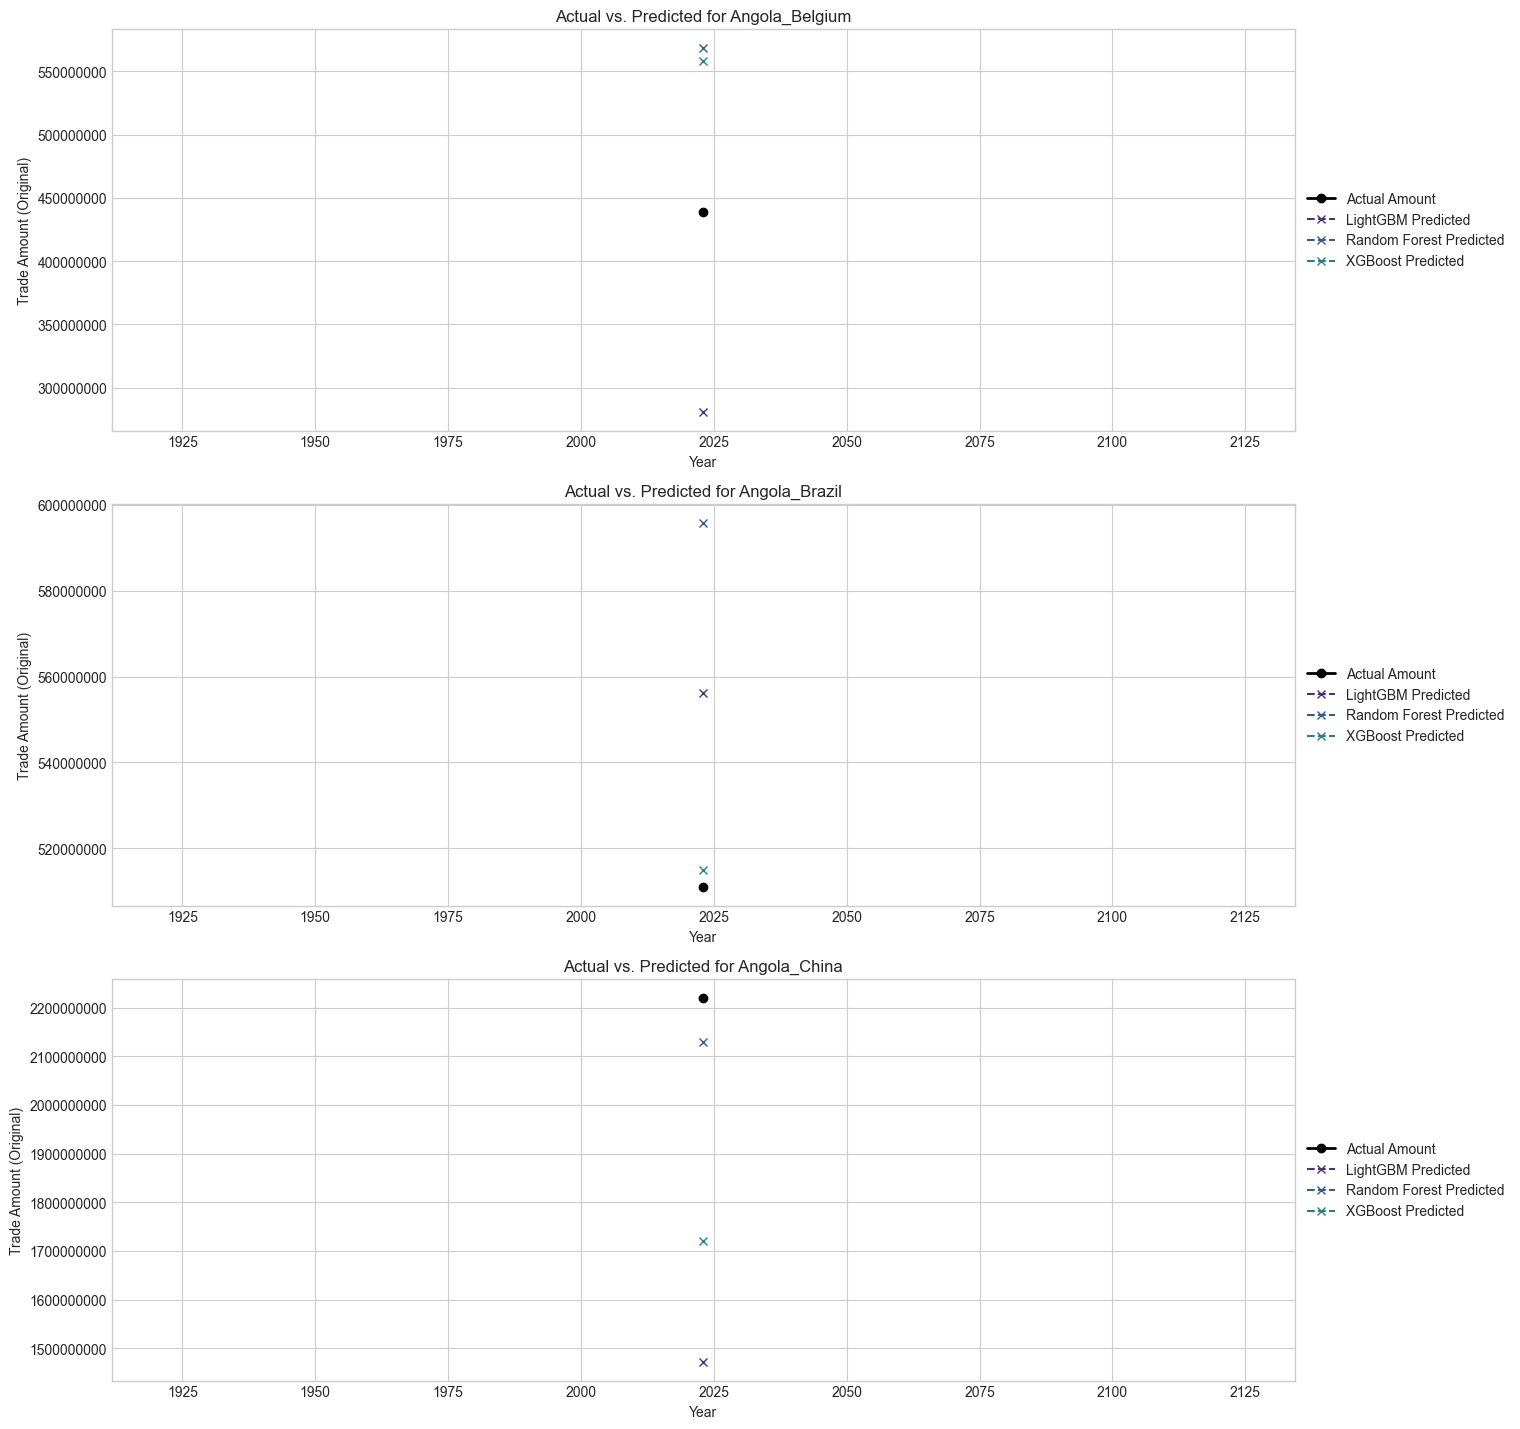

In [7]:
df_performance_final = pd.DataFrame(model_performance_summary)
print("\n--- Overall Model Performance Summary ---")
if not df_performance_final.empty:
    print(df_performance_final.sort_values(by='RMSE'))
    df_performance_final.to_csv(FINAL_MODEL_PERFORMANCE_FILE, index=False)
    print(f"\nFinal performance summary saved to {FINAL_MODEL_PERFORMANCE_FILE}")
else:
    print("No models were evaluated, or summary is empty.")

if not X_test_final.empty and not y_test_final.empty:
    plot_df_list_viz = []
    
    actuals_for_plot = y_test_full_info.set_index(X_test_final.index) # Align index if necessary
    actuals_for_plot = actuals_for_plot[['year', 'trade_pair_id', TARGET_COLUMN_ORIGINAL]]
    actuals_for_plot.rename(columns={TARGET_COLUMN_ORIGINAL: 'actual_original'}, inplace=True)
    
    # Tree-based model predictions (already aligned with X_test_final index)
    if y_pred_log_lgbm_test is not None:
        temp_df = actuals_for_plot.copy()
        temp_df['predicted_original'] = np.maximum(0, np.expm1(y_pred_log_lgbm_test))
        temp_df['model'] = 'LightGBM'
        plot_df_list_viz.append(temp_df)

    if y_pred_log_rf_test is not None:
        temp_df = actuals_for_plot.copy()
        temp_df['predicted_original'] = np.maximum(0, np.expm1(y_pred_log_rf_test))
        temp_df['model'] = 'Random Forest'
        plot_df_list_viz.append(temp_df)

    if y_pred_log_xgb_test is not None:
        temp_df = actuals_for_plot.copy()
        temp_df['predicted_original'] = np.maximum(0, np.expm1(y_pred_log_xgb_test))
        temp_df['model'] = 'XGBoost'
        plot_df_list_viz.append(temp_df)
        
    # LSTM: predictions are on y_test_seq. We need to map these back to pair_id, year.
    if y_pred_log_lstm_test is not None and y_test_final_for_lstm_plot is not None and 'pair_year_info_test_seq' in locals() and not pair_year_info_test_seq.empty:
        lstm_preds_df = pair_year_info_test_seq.copy()
        lstm_preds_df['actual_original'] = np.maximum(0, np.expm1(y_test_final_for_lstm_plot))
        lstm_preds_df['predicted_original'] = np.maximum(0, np.expm1(y_pred_log_lstm_test))
        lstm_preds_df['model'] = 'LSTM'
        plot_df_list_viz.append(lstm_preds_df[['year', 'trade_pair_id', 'actual_original', 'predicted_original', 'model']])

    if plot_df_list_viz:
        df_plot_viz_combined = pd.concat(plot_df_list_viz)
        # Select example pairs from any of the dataframes in plot_df_list_viz that has 'trade_pair_id'
        # Using y_test_full_info as it contains all original test pairs.
        unique_test_pairs = y_test_full_info['trade_pair_id'].unique()
        example_pairs_viz = unique_test_pairs[:N_EXAMPLE_PAIRS_PLOT] if len(unique_test_pairs) > 0 else []
        
        num_models_to_plot = df_plot_viz_combined['model'].nunique()

        if N_EXAMPLE_PAIRS_PLOT > 0 and len(example_pairs_viz) > 0:
            plt.figure(figsize=(18, N_EXAMPLE_PAIRS_PLOT * max(4, (2 + num_models_to_plot * 0.7)) ))
            for i, pair_id_viz in enumerate(example_pairs_viz):
                ax = plt.subplot(N_EXAMPLE_PAIRS_PLOT, 1, i + 1)
                
                # Plot actuals once for this pair
                actual_data_for_pair = df_plot_viz_combined[
                    (df_plot_viz_combined['trade_pair_id'] == pair_id_viz)
                ][['year', 'actual_original']].drop_duplicates().sort_values('year')
                
                if not actual_data_for_pair.empty:
                    ax.plot(actual_data_for_pair['year'], actual_data_for_pair['actual_original'], 
                            label='Actual Amount', marker='o', linestyle='-', color='black', linewidth=2, zorder=10)

                for model_name_viz in sorted(df_plot_viz_combined['model'].unique()):
                    model_pair_data_viz = df_plot_viz_combined[
                        (df_plot_viz_combined['trade_pair_id'] == pair_id_viz) & 
                        (df_plot_viz_combined['model'] == model_name_viz)
                    ].sort_values('year')
                    if not model_pair_data_viz.empty:
                        ax.plot(model_pair_data_viz['year'], model_pair_data_viz['predicted_original'], 
                                label=f'{model_name_viz} Predicted', marker='x', linestyle='--')
                
                ax.set_title(f'Actual vs. Predicted for {pair_id_viz}')
                ax.set_xlabel('Year'); ax.set_ylabel('Trade Amount (Original)')
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                ax.ticklabel_format(style='plain', axis='y')
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.savefig(os.path.join(MODELS_DIR, 'actual_vs_predicted_comparison.png'))
            plt.show()
    else:
        print("No model predictions for combined plotting.")
else:
    print("Test set empty, skipping plots.")

## End of Part 6

This notebook has successfully implemented, tuned, and evaluated a range of advanced forecasting models. Key achievements include:
- Training and evaluating three powerful tree-based ensembles: LightGBM, Random Forest, and XGBoost.
- Identifying XGBoost as the best-performing model based on comprehensive evaluation metrics.
- Implementing an LSTM network, which served as an important point of comparison, demonstrating the strengths of tree-based models on this specific tabular dataset.
- Systematically comparing all advanced models against each other and the baselines from Part 5.
- Generating insightful visualizations, including feature importance plots and actual vs. predicted graphs, to understand model behavior.
- Saving the trained models and the final performance summary, setting the stage for deep model interpretation in the subsequent parts.